# Testing if we can decoder HMM from sequences deterministically

In [1]:
import sys
sys.path.append('/home/mila/l/leo.gagnon/latent_control')

%load_ext autoreload
%autoreload 2
from lightning_modules.diffusion_prior import DiffusionPriorTask
import torch
import matplotlib.pyplot as plt
from data.diffusion import LatentDiffusionDataset, LatentDiffusionDatasetConfig
from models.encoder import DiffusionEncoder
from torch2jax import j2t, t2j
import lightning as L
from models.x_transformer import Encoder, ScaledSinusoidalEmbedding
from lightning_modules.metalearn import MetaLearningTask
import torch.nn as nn
from torch.utils.data import random_split, DataLoader
from einops import rearrange, repeat
import jax.numpy as jnp
import pyvene as pv
import dataclasses
from transformers import PretrainedConfig, BatchEncoding
from tqdm import tqdm

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/mila/l/leo.gagnon/late

In [35]:
task = MetaLearningTask('3gx9owf7').cuda()

Loaded dataset : (11288/1000)
Loaded checkpoing : last.ckpt


In [36]:
pp=task.evaluate_pp(100, n_steps=200)

100it [00:48,  2.04it/s]


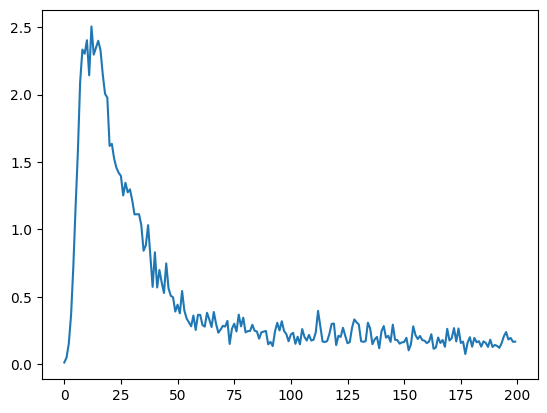

In [37]:
plt.plot(pp['BackwardKL'].mean(0))

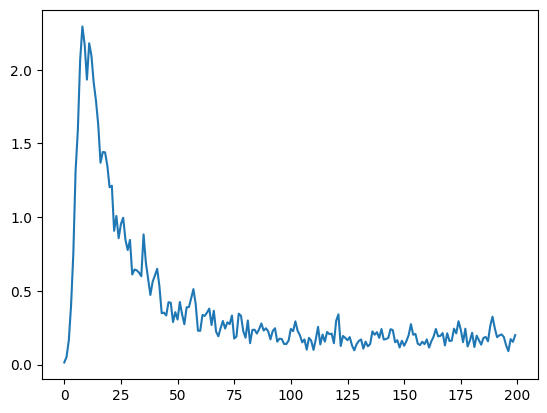

In [18]:
plt.plot(pp['BackwardKL'].mean(0))

In [22]:
class RNNDecoder(L.LightningModule):
    def __init__(
        self,
        pretrained_id: str,
        batch_size: int,
        val_split: float,
        latent_dim: int,
        latent_type: str,
        lr: float,
    ):
        super().__init__()

        self.batch_size = batch_size
        self.val_split = val_split
        self.lr = lr
        self.latent_type = latent_type

        self.base_task = MetaLearningTask(pretrained_id)
        for param in self.base_task.parameters():
            param.requires_grad = False

        self.out_proj = nn.ModuleList(
            [
                nn.Linear(latent_dim, latent_shape)
                for latent_shape in self.base_task.full_data.latent_shape
            ]
        )

    def setup(self, stage):
        with torch.no_grad():
            self.train_data = LatentDiffusionDataset(
                LatentDiffusionDatasetConfig(context_length=[200, 200], cond_tokens_type=None, latent_type=self.latent_type),
                self.base_task,
                None,
            )

    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return opt

    def train_dataloader(self):
        return DataLoader(
            self.train_data,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=lambda x: x,
        )

    def training_step(self, batch, batch_idx=None):

        bs = batch['latent'].shape[0]
        pred = [proj(batch['latent'].reshape(bs,-1)) for proj in self.out_proj]

        loss = sum(
            [
                nn.functional.cross_entropy(pred[i].squeeze(), batch['raw_latent'][:, i]).mean()
                for i in range(len(pred))
            ]
        )
        acc = sum(
            [
                (pred[i].squeeze().argmax(1) == batch['raw_latent'][:, i]).float().mean()
                for i in range(len(pred))
            ]
        ) / len(pred)
        # loss = torch.mean((pred - latent)**2)

        self.log(
            "train/loss",
            loss.detach().cpu().numpy().item(),
            prog_bar=True,
        )
        self.log(
            "train/acc",
            acc.detach().cpu().numpy().item(),
            prog_bar=True,
        )

        return loss

In [23]:
trainer = L.Trainer(
        max_steps=10000,
        accelerator='gpu',
        enable_checkpointing=False,
        val_check_interval=None,
        reload_dataloaders_every_n_epochs=1,
        check_val_every_n_epoch=None,
    )

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/mila/l/leo.gagnon/latent_control/venv/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [38]:
deterministic_encoder = RNNDecoder('qj25w89t', 512, 0.1, 6*512, 'gru_state', 1e-4).cuda()

Loaded dataset : (11288/1000)
Loaded checkpoing : last.ckpt


In [39]:
deterministic_encoder.setup('lol')

In [44]:
deterministic_encoder.train_data.__getitems__([0,1,2])

/home/mila/l/leo.gagnon/latent_control/data/hmm.py:608: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  intv_envs = jnp.array(intv_envs)


{'raw_latent': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]], device='cuda:0'),
 'cond_input_ids': tensor([[41,  9, 28, 11, 26, 49, 13, 26,  9, 35,  9, 11, 26,  5,  9, 18, 11,  1,
          26, 36, 39, 11, 36,  1, 18, 14, 16, 13, 37, 41, 28,  3,  9, 39, 34, 40,
           1, 18,  8, 28, 18, 28,  9, 10,  8, 16, 26, 35, 28,  9],
         [ 9, 42, 26,  9, 28, 47,  9, 35, 49, 36,  9, 28, 41,  9, 47, 37, 26,  9,
          42, 40, 47, 18,  1, 41, 47, 28, 39, 47, 28, 40, 26, 23, 18, 16, 26, 20,
          28, 39,  1,  9, 28, 37,  9, 11, 26, 37, 16, 41,  9, 47],
         [48, 16, 47,  6, 39, 28, 49, 10, 24,  9, 37, 26, 49, 10, 28,  6, 26,  9,
          21, 24,  9, 26, 28, 26,  9,  9, 18,  9, 42, 28, 23, 39, 26, 16,  9, 39,
           1, 18, 28,  9, 48,  9,  1, 16, 47, 39, 26, 29,  9,  9]],
        device='cuda:0', dtype=torch.int32),
 'cond_ignore_mask': tensor([[False, False, False, False, False, Fals

In [27]:
trainer.fit(deterministic_encoder)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | base_task | MetaLearningTask | 9.5 M  | train
1 | out_proj  | ModuleList       | 83.0 K | train
-------------------------------------------------------
83.0 K    Trainable params
9.5 M     Non-trainable params
9.6 M     Total params
38.363    Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/home/mila/l/leo.gagnon/latent_control/data/hmm.py:608: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  intv_envs = jnp.array(intv_envs)
/home/mila/l/leo.gagnon/latent_control/data/hmm.py:608: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  intv_envs = jnp.array(intv_envs)
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.

Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [34]:
6 * 512

3072

In [7]:
deterministic_encoder.cuda();

In [8]:
idx = torch.randperm(len(deterministic_encoder.train_data))[:512]

In [9]:
raw_latent, latent, cond_input_ids, _ = deterministic_encoder.train_data.__getitems__(idx).values()

In [12]:
#cond = deterministic_encoder.seq_conditional_emb(cond_input_ids)
#cond = cond + deterministic_encoder.seq_conditional_posemb(cond)

cond = deterministic_encoder.base_task.model.decoder(cond_input_ids, return_embeddings=True)
cond = deterministic_encoder.cond_proj(cond)

init_emb = repeat(deterministic_encoder.null_embedding.weight, "1 d -> b 1 d", b=raw_latent.shape[0])

pred = deterministic_encoder.latent_model(
        init_emb,
        context=cond,
    )
pred = deterministic_encoder.norm(pred)
pred = [proj(pred) for proj in deterministic_encoder.out_proj]

loss = sum([nn.functional.cross_entropy(pred[i].squeeze(), raw_latent[:,i]).mean() for i in range(len(pred))])
acc = [(pred[i].squeeze().argmax(1) == raw_latent[:,i]).float().mean(0) for i in range(len(pred))]

In [14]:
dataset = deterministic_encoder.base_task.full_data

In [15]:
oracle_out = dataset.bayesian_oracle(jnp.arange(len(dataset)), t2j(cond_input_ids[0]))

In [16]:
jnp.exp(oracle_out['log_alpha_post'][-1]).argmax(), idx[0]

(Array(5126, dtype=int32), tensor(5126))